REGRESIÓN

In [ ]:
import pandas as pd
df_final = pd.read_csv("/content/df_final.csv")

In [ ]:
df_copia_final = df_final.copy()
df_copia_final.drop("PID", axis=1, inplace=True)
df_copia_final.drop("SalePrice", axis=1, inplace=True)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ========= 1) Cargar =========


# ========= 2) One-hot encoding =========
cat_cols = df_copia_final.select_dtypes(include=["object"]).columns.tolist()
df_dummies = pd.get_dummies(df_copia_final, columns=cat_cols, drop_first=True)

# ========= 3) Definir X e y =========
y = df_dummies["SalePrice_Present"]
X = df_dummies.drop(columns=["SalePrice_Present"], errors="ignore")

# ========= 4) Limpieza robusta de tipos =========
# a) detectar columnas no numéricas (debería ser 0 tras get_dummies)
obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
if obj_cols:
    # Intentar convertir forzando error si no se puede
    for c in obj_cols:
        X[c] = pd.to_numeric(X[c], errors="raise")

# b) convertir booleanos a int (por si acaso)
bool_cols = X.select_dtypes(include=["bool"]).columns.tolist()
for c in bool_cols:
    X[c] = X[c].astype(int)

# c) asegurar que y también sea numérica
y = pd.to_numeric(y, errors="raise")

# d) quitar inf/-inf si los hubiera
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)
# (no deberías tener NaN, pero por si acaso)
X = X.dropna(axis=1, how="any")
# Si y tuviera NaN (raro), filtra filas:
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

# ========= 5) Agregar constante e intentar OLS =========
X = sm.add_constant(X, has_constant="add")

try:
    model = sm.OLS(y.values.astype(float), X.values.astype(float)).fit()
    print(model.summary())
except Exception as e:
    print("Falló el ajuste. Revisando columnas problemáticas…\n", e)
    # Detección fina: cuáles columnas no son numéricas estrictamente
    bad = []
    for c in X.columns:
        try:
            pd.to_numeric(X[c], errors="raise")
        except Exception:
            bad.append(c)
    print("\nColumnas no numéricas:", bad)
    print("\nDtypes de X:\n", X.dtypes.value_counts())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     214.7
Date:                Fri, 12 Sep 2025   Prob (F-statistic):               0.00
Time:                        22:57:09   Log-Likelihood:                -34688.
No. Observations:                2914   AIC:                         6.964e+04
Df Residuals:                    2780   BIC:                         7.045e+04
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.594e+05   1.72e+05     -5.579      0.0

In [ ]:
import numpy as np

y_real = y   # tus valores reales (ej. log(SalePrice_Present) o SalePrice_Present)
y_pred = model.fittedvalues  # predicciones del modelo

mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100
print("MAPE:", mape)

MAPE: 10.08629586448787


Lo normal es una kurtosis de 3 aprox muchas colas

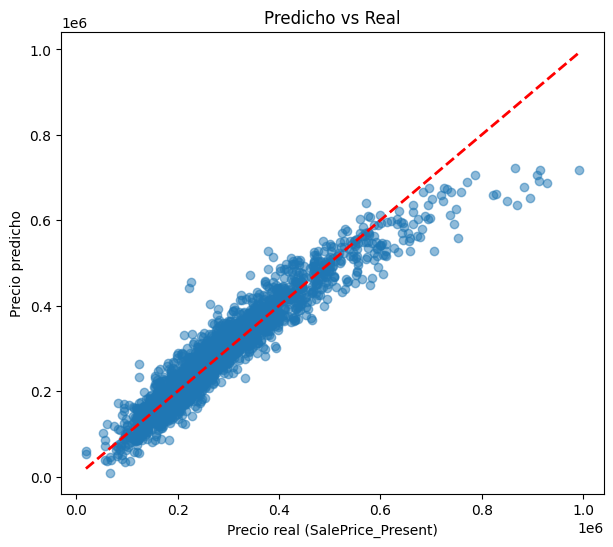

In [ ]:
import matplotlib.pyplot as plt

# Valores ajustados y residuales
y_pred = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(7,6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)  # línea ideal
plt.xlabel("Precio real (SalePrice_Present)")
plt.ylabel("Precio predicho")
plt.title("Predicho vs Real")
plt.show()

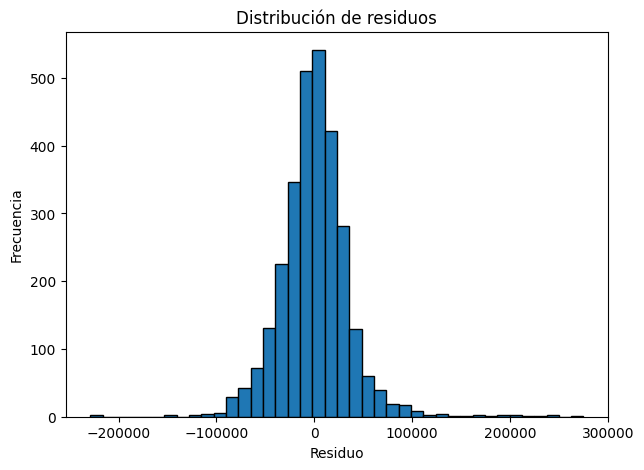

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=40, edgecolor='black')
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.title("Distribución de residuos")
plt.show()

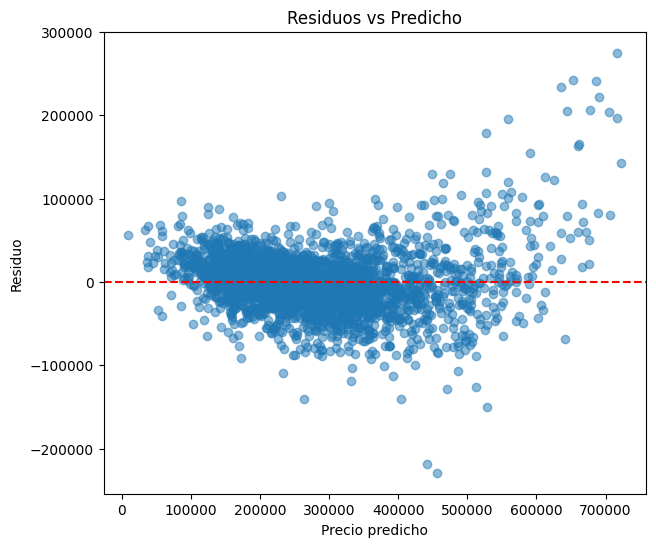

In [ ]:
plt.figure(figsize=(7,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Precio predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs Predicho")
plt.show()


Log Sale Price present

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- 1. Convertir variables categóricas a dummies ---
cat_cols = df_copia_final.select_dtypes(include=["object"]).columns.tolist()
d = pd.get_dummies(df_copia_final, columns=cat_cols, drop_first=True)

# --- 2. Variable dependiente en log ---
y = np.log(d["SalePrice_Present"].astype(float))

# --- 3. Variables predictoras ---
X = d.drop(columns=["SalePrice_Present"], errors="ignore")
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")
X = X.astype(float)
X = sm.add_constant(X, has_constant="add")  # agrega constante

# --- 4. Ajustar modelo OLS ---
m_log = sm.OLS(y, X).fit()

# --- 5. Mostrar resumen completo ---
print(m_log.summary())

# --- 6. Calcular RMSE ---
residuals = m_log.resid
rmse = np.sqrt(np.mean(residuals**2))
print("RMSE del modelo OLS (log SalePrice_Present): {:.5f}".format(rmse))

# --- 7. Coeficientes ordenados por significancia (p-valor) ---
res = pd.DataFrame({"coef": m_log.params, "pval": m_log.pvalues})
res = res.sort_values("pval")  # más significativas arriba
print(res.head(20))

                            OLS Regression Results                            
Dep. Variable:      SalePrice_Present   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     258.2
Date:                Fri, 12 Sep 2025   Prob (F-statistic):               0.00
Time:                        22:57:10   Log-Likelihood:                 2254.7
No. Observations:                2914   AIC:                            -4241.
Df Residuals:                    2780   BIC:                            -3440.
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
y_real = df_final["SalePrice_Present"]         # valor real en nivel
y_pred = np.exp(m_log.fittedvalues)  # predicción en nivel

mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100
print("MAPE:", mape)

# --- 6A. RMSE en log (ya estaba en tu código) ---
residuals = m_log.resid
rmse_log = np.sqrt(np.mean(residuals**2))
print("RMSE en escala logarítmica: {:.5f}".format(rmse_log))

# --- 6B. RMSE en nivel original (SalePrice_Present) ---
rmse_nivel = np.sqrt(np.mean((y_real - y_pred) ** 2))
print("RMSE en escala original (SalePrice_Present): {:.2f}".format(rmse_nivel))

MAPE: 7.98121170506915
RMSE en escala logarítmica: 0.11162
RMSE en escala original (SalePrice_Present): 29419.15


In [ ]:
res = pd.DataFrame({
    "coef": m_log.params,
    "pval": m_log.pvalues
})
res = res.sort_values("pval")  # más significativas arriba
print(res.head(25))

                                    coef           pval
Gr Liv Area                     0.000290  2.352673e-137
Overall Qual                    0.054110   1.731416e-62
Overall Cond                    0.041663   3.670221e-49
const                           5.245492   3.247377e-22
Total Bsmt SF                   0.000095   2.520963e-21
MS Zoning_RL                    0.916873   1.911369e-20
MS Zoning_RH                    0.937512   3.100127e-20
MS Zoning_RM                    0.869424   1.749244e-18
MS Zoning_FV                    0.883016   2.918924e-18
Sale Condition_Normal           0.084076   7.614673e-18
Year Built                      0.001864   7.794651e-16
Garage Cars                     0.041415   3.254044e-15
Bsmt Exposure                   0.019912   3.391989e-13
MS Zoning_C (all)               0.728852   5.876510e-13
TotalPorch                      0.000150   3.490891e-11
MS Zoning_I (all)               0.835071   1.018678e-10
Lot Area                        0.000002   1.122

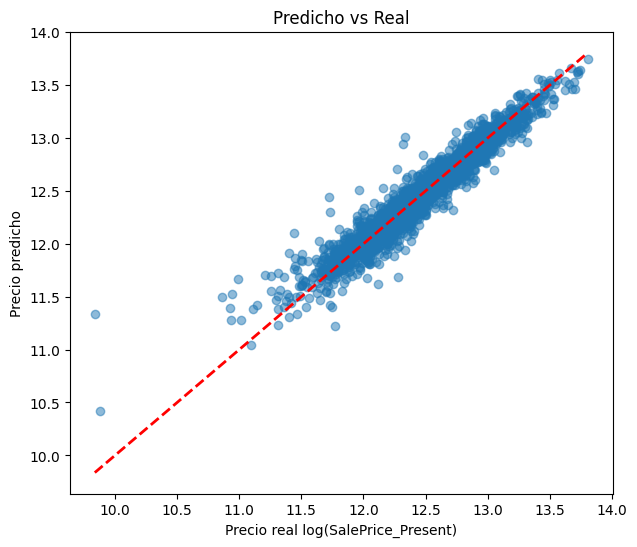

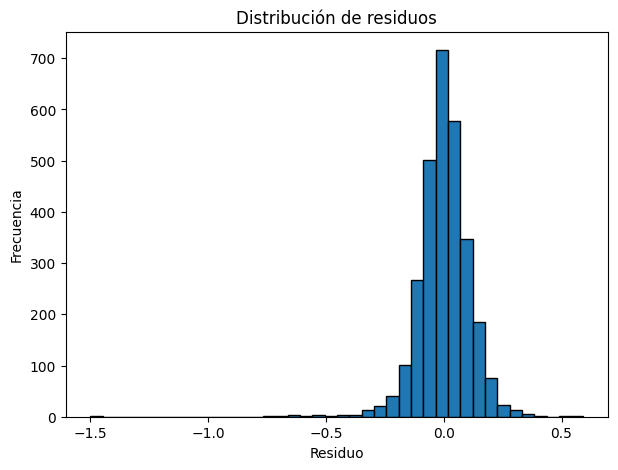

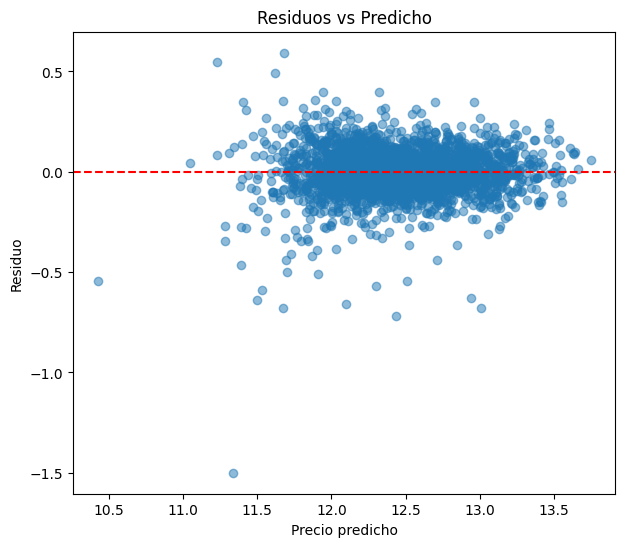

In [ ]:
import matplotlib.pyplot as plt

# Valores ajustados y residuales
y_pred = m_log.fittedvalues
residuals = m_log.resid

plt.figure(figsize=(7,6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)  # línea ideal
plt.xlabel("Precio real log(SalePrice_Present)")
plt.ylabel("Precio predicho")
plt.title("Predicho vs Real")
plt.show()

plt.figure(figsize=(7,5))
plt.hist(residuals, bins=40, edgecolor='black')
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.title("Distribución de residuos")
plt.show()

plt.figure(figsize=(7,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Precio predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs Predicho")
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
Xv = X.drop(columns=["const"])
vif = pd.DataFrame({
    "variable": Xv.columns,
    "VIF": [variance_inflation_factor(Xv.values, i) for i in range(Xv.shape[1])]
}).sort_values("VIF", ascending=False)
print(vif.head(20))

                   variable           VIF
3            Year Remod/Add  20152.121635
2                Year Built  19983.775271
45             MS Zoning_RL   1576.898219
46             MS Zoning_RM    321.964575
87         Roof Style_Gable    249.967848
29              Garage Qual    175.672373
34   Roof_Matl_simplificado    150.454388
42             MS Zoning_FV    101.474686
19               Exter Cond     93.037081
113      Garage Type_Attchd     87.616108
17             Overall Qual     86.466061
21                Bsmt Cond     81.443366
20                Bsmt Qual     79.596424
26             Kitchen Qual     72.934892
6               Gr Liv Area     64.838207
89           Roof Style_Hip     60.398635
18             Overall Cond     55.153342
124           Sale Type_New     47.625736
132  Sale Condition_Partial     45.630408
12            Kitchen AbvGr     44.989224


In [ ]:
import pandas as pd, numpy as np, statsmodels.api as sm

cat_cols = df_copia_final.select_dtypes(include=["object"]).columns.tolist()
d = pd.get_dummies(df_copia_final, columns=cat_cols, drop_first=True)

# y en log
y = np.log(d["SalePrice_Present"].astype(float))

#if "Gr Liv Area" in d.columns:
    #d["log_GrLivArea"] = np.log1p(d["Gr Liv Area"])  # log(1+x) evita problemas con 0
    # (opcional) puedes luego quitar "Gr Liv Area" cruda para evitar colinealidad:
   # d = d.drop(columns=["Gr Liv Area"])

#for c in ["Full Bath","Half Bath","Bsmt Full Bath","Bsmt Half Bath"]:
    #if c not in d.columns: d[c] = 0
#d["TotalBaths"] = d["Full Bath"] + 0.5*d["Half Bath"] + d["Bsmt Full Bath"] + 0.5*d["Bsmt Half Bath"]
# puedes remover las originales si quieres reducir colinealidad:
#d = d.drop(columns=["Full Bath","Half Bath","Bsmt Full Bath","Bsmt Half Bath"])

#if "Total Bsmt SF" in d.columns:
 # d["log_TotalBsmtSF"] = np.log1p(d["Total Bsmt SF"])
 # d = d.drop(columns=["Total Bsmt SF"])

#if "Lot Area" in d.columns:
  #d["log_LotArea"] = np.log1p(d["Lot Area"])
  #d = d.drop(columns=["Lot Area"])
# X numérica y limpia, PERO SIGUE SIENDO DATAFRAME
X = d.drop(columns=["SalePrice_Present"], errors="ignore")

X = X.replace([np.inf,-np.inf], np.nan).dropna(axis=1, how="any")
X = X.astype(float)
X = sm.add_constant(X, has_constant="add")

# Ajustar SIN convertir a numpy
m_log = sm.OLS(y, X).fit()
print(m_log.summary())         # <- ahora salen los nombres verdaderos
res = pd.DataFrame({"coef": m_log.params, "pval": m_log.pvalues})
res = res.sort_values("pval")        # más significativas arriba
res.head(20)

                            OLS Regression Results                            
Dep. Variable:      SalePrice_Present   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     258.2
Date:                Fri, 12 Sep 2025   Prob (F-statistic):               0.00
Time:                        22:57:27   Log-Likelihood:                 2254.7
No. Observations:                2914   AIC:                            -4241.
Df Residuals:                    2780   BIC:                            -3440.
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,coef,pval
Gr Liv Area,0.000290,2.352673e-137
Overall Qual,0.054110,1.731416e-62
Overall Cond,0.041663,3.670221e-49
const,5.245492,3.247377e-22
Total Bsmt SF,0.000095,2.520963e-21
MS Zoning_RL,0.916873,1.911369e-20
MS Zoning_RH,0.937512,3.100127e-20
MS Zoning_RM,0.869424,1.749244e-18
MS Zoning_FV,0.883016,2.918924e-18
Sale Condition_Normal,0.084076,7.614673e-18


In [ ]:
#lo mismo que antes!!!1 este si funconaba

import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- 1) Convertir variables categóricas a dummies ---
cat_cols = df_copia_final.select_dtypes(include=["object"]).columns.tolist()
d = pd.get_dummies(df_copia_final, columns=cat_cols, drop_first=True)

# --- 2) Variable dependiente en log y variables predictoras ---
y_log = np.log(d["SalePrice_Present"].astype(float))
X = d.drop(columns=["SalePrice_Present"], errors="ignore")

# --- 3) Limpiar inf/NaN y asegurar float ---
X = X.replace([np.inf, -np.inf], np.nan)
y_log = y_log.replace([np.inf, -np.inf], np.nan)

# eliminar filas con NaN en y o en cualquier columna de X
mask = y_log.notna() & ~X.isna().any(axis=1)
X = X.loc[mask].astype(float)
y_log = y_log.loc[mask].astype(float)

# agregar constante
X = sm.add_constant(X, has_constant="add")

# --- 4) Ajustar modelo OLS ---
model_log = sm.OLS(y_log.values.astype(float), X.values.astype(float)).fit()

# --- 5) Mostrar resumen completo ---
print(model_log.summary())

# --- 6) Calcular RMSE ---
residuals = model_log.resid
rmse = np.sqrt(np.mean(residuals**2))
print("RMSE del modelo OLS (log SalePrice_Present): {:.5f}".format(rmse))

# --- 7) Coeficientes ordenados por p-valor ---
res = pd.DataFrame({"coef": model_log.params, "pval": model_log.pvalues})
res = res.sort_values("pval")  # más significativas arriba
print(res.head(20))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     258.2
Date:                Fri, 12 Sep 2025   Prob (F-statistic):               0.00
Time:                        22:57:27   Log-Likelihood:                 2254.7
No. Observations:                2914   AIC:                            -4241.
Df Residuals:                    2780   BIC:                            -3440.
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2455      0.537      9.776      0.0

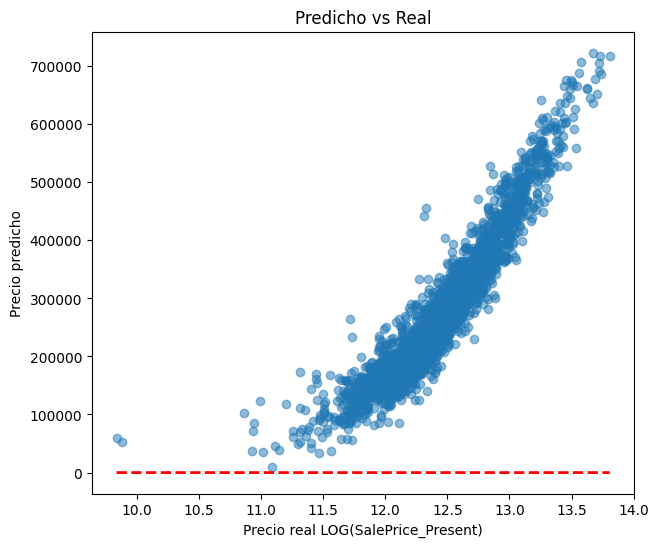

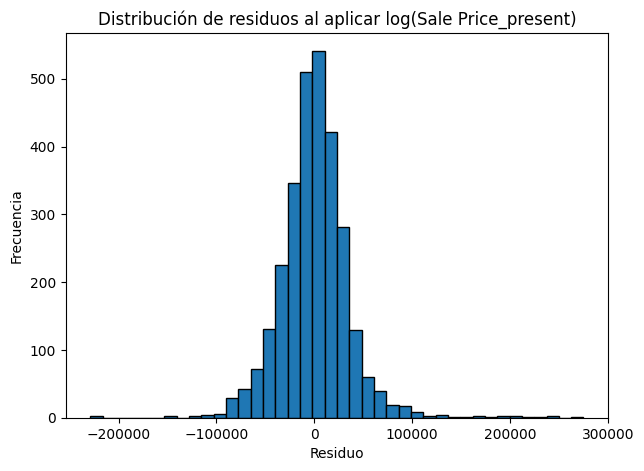

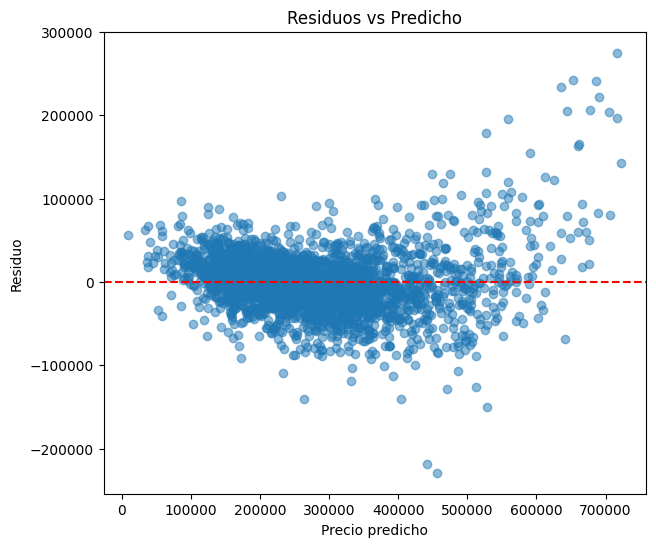

In [ ]:
import matplotlib.pyplot as plt

# Valores ajustados y residuales
y_pred = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(7,6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)  # línea ideal
plt.xlabel("Precio real LOG(SalePrice_Present)")
plt.ylabel("Precio predicho")
plt.title("Predicho vs Real")
plt.show()

plt.figure(figsize=(7,5))
plt.hist(residuals, bins=40, edgecolor='black')
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.title("Distribución de residuos al aplicar log(Sale Price_present)")
plt.show()

plt.figure(figsize=(7,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Precio predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs Predicho")
plt.show()

REGRESIÓN LASSO

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# --- Definir el modelo base ---
lasso = Lasso(max_iter=10000)

# --- Definir la grilla de hiperparámetros ---
param_grid = {
    "alpha": np.logspace(-4, 1, 50)  # valores de alpha entre 1e-4 y 10
}

# --- Definir GridSearch ---
lasso_grid = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    scoring="r2",     # puedes usar "neg_mean_squared_error" o "r2"
    cv=5,
    n_jobs=-1
)

lasso_grid.fit(X_train, y_train)
lasso_final = lasso_grid.best_estimator_

NameError: name 'X_train' is not defined

R² test (nivel real): 0.92817
MAPE test (nivel real): 8.20147
RMSE test (nivel real): 32680.20768
Skewness residuos: 1.19523
Kurtosis residuos: 6.86411
Neighborhood_Crawfor              0.108549
Sale Type_New                     0.083786
Sale Condition_Normal             0.075963
Neighborhood_MeadowV             -0.067118
MS Zoning_RL                      0.063497
Overall Qual                      0.063028
Exterior 1st_BrkFace              0.062328
Neighborhood_StoneBr              0.061645
Neighborhood_Somerst              0.058488
Sale Condition_Partial            0.056370
Central Air_Y                     0.051389
FunctioNo aplical_simplificado    0.044037
Overall Cond                      0.043782
MS Zoning_C (all)                -0.040216
Neighborhood_NridgHt              0.039782
Condition 1_Norm                  0.039440
Neighborhood_BrkSide              0.038777
Bsmt Full Bath                    0.037621
Paved_Drive_simplificado          0.034308
Garage Cars                    

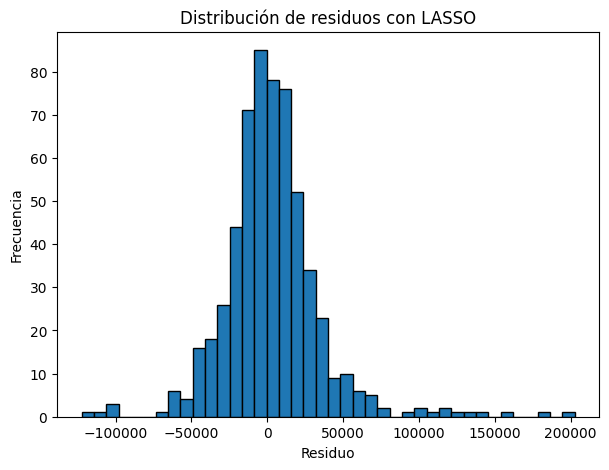

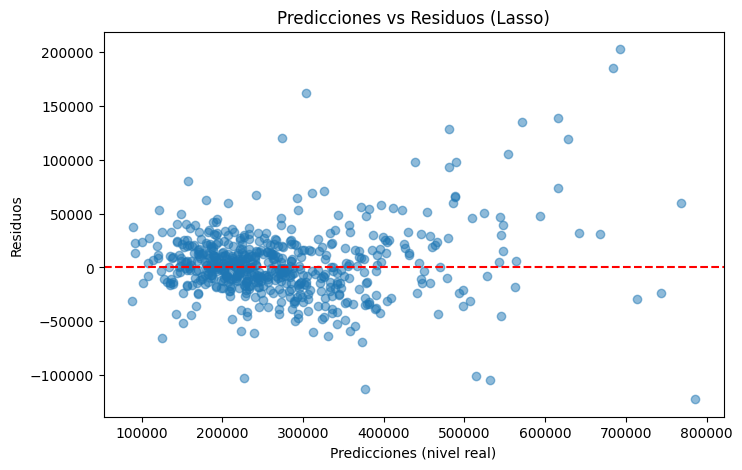

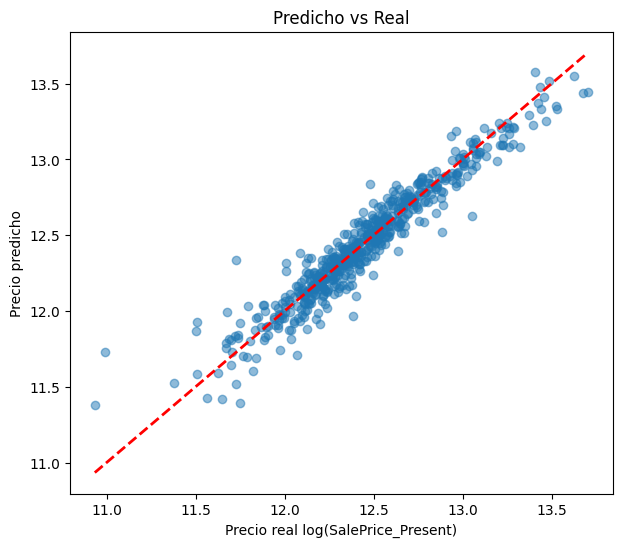

Text(0.5, 1.0, 'Predicho vs Real (nivel real)')

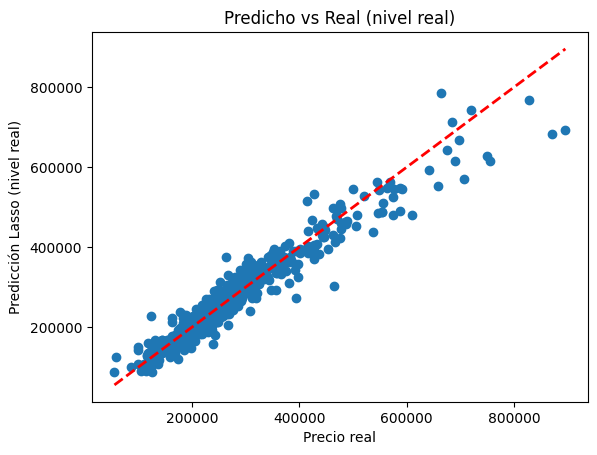

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# --- 1. Variable dependiente en log ---
y_log = np.log(df_final["SalePrice_Present"])

# --- 2. División train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# --- 3. Entrenamiento con mejor Lasso encontrado ---
lasso_grid.fit(X_train, y_train)               # grid search ya definido antes
lasso_final = lasso_grid.best_estimator_       # mejor modelo

# --- 4. Predicciones ---
y_test_pred_log = lasso_final.predict(X_test)  # predicciones en log
y_test_pred = np.exp(y_test_pred_log)          # volver a escala real
y_real = np.exp(y_test)                        # valores reales en escala real

# --- 5. Métricas ---
r2_real = r2_score(y_real, y_test_pred)
mape_real = mean_absolute_percentage_error(y_real, y_test_pred) * 100
rmse_real = np.sqrt(mean_squared_error(y_real, y_test_pred))

# --- 6. Residuos (en escala real) ---
residuals = y_real - y_test_pred
skewness = skew(residuals)
kurt = kurtosis(residuals)

print(f"R² test (nivel real): {r2_real:.5f}")
print(f"MAPE test (nivel real): {mape_real:.5f}")
print(f"RMSE test (nivel real): {rmse_real:.5f}")
print(f"Skewness residuos: {skewness:.5f}")
print(f"Kurtosis residuos: {kurt:.5f}")


coef = pd.Series(lasso_final.coef_, index=X.columns)
coef_sorted = coef.sort_values(key=abs, ascending=False)
print(coef_sorted.head(25))  # las 20 variables más importantes

# --- 7. Gráficos ---
# Histograma de residuos
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=40, edgecolor='black')
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.title("Distribución de residuos con LASSO")
plt.show()

# Scatterplot de residuos
plt.figure(figsize=(8,5))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicciones (nivel real)")
plt.ylabel("Residuos")
plt.title("Predicciones vs Residuos (Lasso)")
plt.show()

# Gráfico de regresión (valores reales vs predichos)
# Gráfico de regresión Lasso (estilo solicitado)
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_test_pred_log, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)  # línea ideal
plt.xlabel("Precio real log(SalePrice_Present)")
plt.ylabel("Precio predicho")
plt.title("Predicho vs Real")
plt.show()

plt.scatter(np.exp(y_test), np.exp(y_test_pred_log))
plt.plot([np.exp(y_test).min(), np.exp(y_test).max()],
         [np.exp(y_test).min(), np.exp(y_test).max()], 'r--', linewidth=2)
plt.xlabel("Precio real")
plt.ylabel("Predicción Lasso (nivel real)")
plt.title("Predicho vs Real (nivel real)")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Coeficientes del modelo final ---
coefs = pd.DataFrame({
    'coefs': lasso_final.coef_,
    'Positive': lasso_final.coef_ > 0
}, index=X_train.columns)

coefs['coefs_abs'] = np.abs(coefs.coefs)

# Cuántas variables fueron eliminadas (coef = 0)
print('LASSO dropped {} of {} features.'.format(
    sum(coefs.coefs == 0), coefs.shape[0]
))

# Top 20 coeficientes en valor absoluto
top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(20)

# --- Gráfico ---
plt.figure(figsize=(8,10))
sns.barplot(
    x=top_coefs.coefs_abs,
    y=top_coefs.index,
    hue=top_coefs.Positive,
    dodge=False
)
plt.title('LASSO Regression: Top 20 Features')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.legend(title='Positive Coefficient')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Coeficientes OLS ---
res_ols = pd.DataFrame({
    "Variable": m_log.params.index,
    "Coeficiente": m_log.params.values,
    "p-valor": m_log.pvalues.values
})

# Ordenar por significancia (p-valor)
res_ols_sig = res_ols.sort_values("p-valor").reset_index(drop=True)
print("----- OLS: variables más significativas -----")
print(res_ols_sig.head(20))


# --- Identificar variables no significativas (p > 0.05) ---
vars_no_sig = res_ols[res_ols["p-valor"] > 0.05]

print("----- Variables NO significativas (p > 0.05) -----")
print(vars_no_sig[["Variable", "p-valor"]])

# --- Guardar lista de variables a eliminar ---
vars_a_eliminar = vars_no_sig["Variable"].tolist()

print("\nSe eliminarán", len(vars_a_eliminar), "variables:")
print(vars_a_eliminar)

# Total de variables en el modelo
total_vars = res_ols.shape[0]

# Variables con p-valor > 0.05
no_signif = res_ols[res_ols["p-valor"] > 0.05].shape[0]

print(f"Se eliminarían {no_signif} de {total_vars} variables (p-valor > 0.05).")

# --- 2. Coeficientes Lasso ---
coef_lasso = pd.Series(lasso_final.coef_, index=X.columns)

# Variables eliminadas por Lasso (coef = 0)
eliminadas = coef_lasso[coef_lasso == 0].index.tolist()
print(f"\nLasso eliminó {len(eliminadas)} de {len(coef_lasso)} variables.")
print("Variables eliminadas:", eliminadas)

# Variables más importantes (coef != 0)
coef_lasso_sorted = coef_lasso.sort_values(key=abs, ascending=False)
print("\n----- Lasso: variables más importantes -----")
print(coef_lasso_sorted.head(20))

# --- 3. Gráfico comparativo de coeficientes ---
# Tomamos top 20 de OLS (valor absoluto) y Lasso
top_ols = res_ols_sig.iloc[:20]
top_lasso = coef_lasso_sorted.head(20)

plt.figure(figsize=(12,5))

# OLS
plt.subplot(1,2,1)
sns.barplot(x=top_ols["Coeficiente"], y=top_ols["Variable"], palette="Blues_r")
plt.title("Top 20 Coeficientes OLS")
plt.xlabel("Coeficiente")
plt.ylabel("Variable")

# Lasso
plt.subplot(1,2,2)
sns.barplot(x=top_lasso.values, y=top_lasso.index, palette="Oranges_r")
plt.title("Top 20 Coeficientes Lasso")
plt.xlabel("Coeficiente")
plt.ylabel("Variable")

plt.tight_layout()
plt.show()


SE ELIMINAN LAS VARIABLES NO SIGNIFICATIVAS, AQUELLAS QUE TIENEN P-VALUE > 0.05

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import skew, kurtosis

# --- 1. Convertir variables categóricas a dummies ---
cat_cols = df_copia_final.select_dtypes(include=["object"]).columns.tolist()
d = pd.get_dummies(df_copia_final, columns=cat_cols, drop_first=True)

# --- 2. Variable dependiente en log ---
y = np.log(d["SalePrice_Present"].astype(float))

# --- 3. Variables predictoras ---
X = d.drop(columns=["SalePrice_Present"], errors="ignore")
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")
X = X.astype(float)
X = sm.add_constant(X, has_constant="add")

# --- 4. Ajustar modelo OLS inicial ---
m_log = sm.OLS(y, X).fit()
print("Modelo inicial ajustado.")
print(m_log.summary())

# --- 5. Identificar variables no significativas ---
pvals = m_log.pvalues
vars_no_signif = pvals[pvals > 0.05].index.tolist()

print(f"\nSe eliminarán {len(vars_no_signif)} de {X.shape[1]} variables por p-valor > 0.05.")

# --- 6. Crear copia de la DB y eliminar esas variables ---
X_refit = X.drop(columns=vars_no_signif, errors="ignore")

# --- 7. Ajustar modelo OLS sin variables no significativas ---
modelo_refit = sm.OLS(y, X_refit).fit()
print("\nModelo reajustado:")
print(modelo_refit.summary())

# --- 8. Predicciones y métricas ---
y_real = df_copia_final["SalePrice_Present"]  # valor real en nivel original
y_pred_log = modelo_refit.fittedvalues        # predicciones en log
y_pred = np.exp(y_pred_log)                   # predicciones en nivel real

# R² ya viene del modelo
r2 = modelo_refit.rsquared

# MAPE
mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

# RMSE en log
residuals = modelo_refit.resid
rmse_log = np.sqrt(np.mean(residuals**2))

# RMSE en escala real
rmse_real = np.sqrt(np.mean((y_real - y_pred) ** 2))

# Skewness y Kurtosis de los residuos
skewness = skew(residuals)
kurt = kurtosis(residuals)

print("\n--- Métricas del modelo reajustado ---")
print(f"R²: {r2:.5f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE (log): {rmse_log:.5f}")
print(f"RMSE (real): {rmse_real:.2f}")
print(f"Skewness de residuos: {skewness:.5f}")
print(f"Kurtosis de residuos: {kurt:.5f}")



In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import skew, kurtosis

# --- 1. Convertir variables categóricas a dummies ---
cat_cols = df_copia_final.select_dtypes(include=["object"]).columns.tolist()
d = pd.get_dummies(df_copia_final, columns=cat_cols, drop_first=True)

# --- 2. Variable dependiente ---
y = np.log(d["SalePrice_Present"].astype(float))

# --- 3. Variables predictoras ---
X = d.drop(columns=["SalePrice_Present"], errors="ignore")
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")
X = X.astype(float)
X = sm.add_constant(X, has_constant="add")

# --- 4. Ajustar modelo OLS inicial ---
m_log = sm.OLS(y, X).fit()
print("Modelo inicial ajustado.")
print(m_log.summary())

# --- 5. Prueba conjunta de bloques categóricos ---
vars_to_remove = []

for col in cat_cols:
    dummies_col = [c for c in X.columns if c.startswith(col + "_")]
    if not dummies_col:  # puede pasar si se eliminó por drop_first
        continue

    # Test conjunto: todos los coeficientes = 0
    test_str = " = ".join([f"{var} = 0" for var in dummies_col])
    f_test = m_log.f_test(test_str)

    if f_test.pvalue > 0.05:
        print(f"Variable '{col}' eliminada (p-valor F-test: {f_test.pvalue:.3f})")
        vars_to_remove.extend(dummies_col)

# --- 6. Reajustar sin bloques no significativos ---
X_refit = X.drop(columns=vars_to_remove, errors="ignore")

modelo_refit = sm.OLS(y, X_refit).fit()
print("\nModelo reajustado:")
print(modelo_refit.summary())

# --- 7. Métricas ---
y_real = df_copia_final["SalePrice_Present"]
y_pred_log = modelo_refit.fittedvalues
y_pred = np.exp(y_pred_log)

r2 = modelo_refit.rsquared
mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100
residuals = modelo_refit.resid
rmse_log = np.sqrt(np.mean(residuals**2))
rmse_real = np.sqrt(np.mean((y_real - y_pred) ** 2))
skewness = skew(residuals)
kurt = kurtosis(residuals)

print("\n--- Métricas del modelo reajustado ---")
print(f"R²: {r2:.5f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE (log): {rmse_log:.5f}")
print(f"RMSE (real): {rmse_real:.2f}")
print(f"Skewness de residuos: {skewness:.5f}")
print(f"Kurtosis de residuos: {kurt:.5f}")



In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import skew, kurtosis

# --- 1. Convertir variables categóricas a dummies ---
cat_cols = df_copia_final.select_dtypes(include=["object"]).columns.tolist()
d = pd.get_dummies(df_copia_final, columns=cat_cols, drop_first=True)

# --- 2. Variable dependiente ---
y = np.log(d["SalePrice_Present"].astype(float))

# --- 3. Variables predictoras ---
X = d.drop(columns=["SalePrice_Present"], errors="ignore")
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")
X = X.astype(float)
X = sm.add_constant(X, has_constant="add")

# --- 4. Ajustar modelo OLS inicial ---
m_log = sm.OLS(y, X).fit()
print("Modelo inicial ajustado.")
print(m_log.summary())

# --- 5. Prueba conjunta de bloques categóricos (ahora guardamos bloques eliminados) ---
vars_to_remove = []       # dummies a eliminar
removed_blocks = []       # nombres de variables categóricas completas eliminadas

for col in cat_cols:
    dummies_col = [c for c in X.columns if c.startswith(col + "_")]
    if not dummies_col:
        continue

    test_str = " = ".join([f"{var} = 0" for var in dummies_col])
    f_test = m_log.f_test(test_str)

    if f_test.pvalue > 0.05:
        print(f"Variable categórica '{col}' eliminada (p-valor F-test: {f_test.pvalue:.3f})")
        removed_blocks.append(col)
        vars_to_remove.extend(dummies_col)

# --- Conteos en términos de bloques y dummies ---
# bloques que tenían dummies en X (consideradas)
blocks_with_dummies = [c for c in cat_cols if any(col_name.startswith(c + "_") for col_name in X.columns)]

num_blocks_considered = len(blocks_with_dummies)
num_blocks_removed = len(removed_blocks)

# dummies totales antes/las que se eliminan
total_dummy_cols = sum(len([col_name for col_name in X.columns if col_name.startswith(block + "_")])
                       for block in blocks_with_dummies)
num_dummy_removed = len(vars_to_remove)

# variables numéricas efectivas (columnas en X que NO son dummies y no son const)
numeric_features = [c for c in X.columns if c != "const" and not any(c.startswith(b + "_") for b in cat_cols)]
num_numeric = len(numeric_features)

# variables "efectivas" = numéricas + bloques categóricos
effective_before = num_numeric + num_blocks_considered
effective_after = num_numeric + (num_blocks_considered - num_blocks_removed)

print("\n--- Resumen por bloques (categóricas vs dummies) ---")
print(f"Categóricas consideradas (con dummies): {num_blocks_considered}")
print(f"Categóricas eliminadas (bloques completos): {num_blocks_removed}")
print(f"Dummies eliminadas (columnas): {num_dummy_removed} de {total_dummy_cols} dummies totales")
print(f"Variables numéricas (efectivas): {num_numeric}")
print(f"Variables efectivas antes: {effective_before}  |  después: {effective_after}")

print("\nLista de bloques eliminados:")
print(removed_blocks)

# --- 6. Reajustar sin bloques no significativos ---
X_refit = X.drop(columns=vars_to_remove, errors="ignore")
modelo_refit = sm.OLS(y, X_refit).fit()
print("\nModelo reajustado:")
print(modelo_refit.summary())

# --- 7. Métricas (igual que antes) ---
y_real = df_copia_final["SalePrice_Present"]
y_pred_log = modelo_refit.fittedvalues
y_pred = np.exp(y_pred_log)

r2 = modelo_refit.rsquared
mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100
residuals = modelo_refit.resid
rmse_log = np.sqrt(np.mean(residuals**2))
rmse_real = np.sqrt(np.mean((y_real - y_pred) ** 2))
skewness = skew(residuals)
kurt = kurtosis(residuals)

print("\n--- Métricas del modelo reajustado ---")
print(f"R²: {r2:.5f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE (log): {rmse_log:.5f}")
print(f"RMSE (real): {rmse_real:.2f}")
print(f"Skewness de residuos: {skewness:.5f}")
print(f"Kurtosis de residuos: {kurt:.5f}")


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import skew, kurtosis

# --- 1. Convertir variables categóricas a dummies ---
cat_cols = df_copia_final.select_dtypes(include=["object"]).columns.tolist()
d = pd.get_dummies(df_copia_final, columns=cat_cols, drop_first=True)

# --- 2. Variable dependiente ---
y = np.log(d["SalePrice_Present"].astype(float))

# --- 3. Variables predictoras ---
X = d.drop(columns=["SalePrice_Present"], errors="ignore")
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")
X = X.astype(float)
X = sm.add_constant(X, has_constant="add")

# --- 4. Ajustar modelo OLS inicial ---
m_log = sm.OLS(y, X).fit()
print("Modelo inicial ajustado.")

# --- 5. Prueba conjunta de bloques categóricos ---
vars_to_remove = []       # dummies a eliminar
removed_blocks = []       # bloques categóricos completos eliminados

for col in cat_cols:
    dummies_col = [c for c in X.columns if c.startswith(col + "_")]
    if not dummies_col:
        continue

    f_test = m_log.f_test(" = ".join([f"{var} = 0" for var in dummies_col]))

    if f_test.pvalue > 0.05:
        removed_blocks.append(col)        # guardamos el bloque completo
        vars_to_remove.extend(dummies_col) # guardamos las dummies
        print(f"Variable categórica '{col}' eliminada (p-valor F-test: {f_test.pvalue:.3f})")

# --- 5.1. Conteo de variables ---
# bloques con dummies que existían
blocks_with_dummies = [c for c in cat_cols if any(c_.startswith(c + "_") for c_ in X.columns)]
num_blocks_considered = len(blocks_with_dummies)
num_blocks_removed = len(removed_blocks)

# dummies totales antes y eliminadas
total_dummy_cols = sum(len([c_ for c_ in X.columns if c_.startswith(block + "_")])
                       for block in blocks_with_dummies)
num_dummy_removed = len(vars_to_remove)

# variables numéricas efectivas
numeric_features = [c for c in X.columns if c != "const" and not any(c.startswith(b + "_") for b in cat_cols)]
num_numeric = len(numeric_features)

# variables efectivas antes y después
effective_before = num_numeric + num_blocks_considered
effective_after = num_numeric + (num_blocks_considered - num_blocks_removed)

print("\n--- Resumen de selección de variables ---")
print(f"Categóricas consideradas (bloques con dummies): {num_blocks_considered}")
print(f"Categóricas eliminadas (bloques completos): {num_blocks_removed}")
print(f"Dummies eliminadas: {num_dummy_removed} de {total_dummy_cols} dummies totales")
print(f"Variables numéricas: {num_numeric}")
print(f"Variables efectivas antes: {effective_before}  |  después: {effective_after}")
print(f"Lista de bloques eliminados: {removed_blocks}")

# --- 6. Reajustar sin bloques no significativos ---
X_refit = X.drop(columns=vars_to_remove, errors="ignore")
modelo_refit = sm.OLS(y, X_refit).fit()

# --- 7. Métricas ---
y_real = df_copia_final["SalePrice_Present"]
y_pred_log = modelo_refit.fittedvalues
y_pred = np.exp(y_pred_log)

r2 = modelo_refit.rsquared
mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100
residuals = modelo_refit.resid
rmse_log = np.sqrt(np.mean(residuals**2))
rmse_real = np.sqrt(np.mean((y_real - y_pred) ** 2))
skewness = skew(residuals)
kurt = kurtosis(residuals)

print("\n--- Métricas del modelo reajustado ---")
print(f"R²: {r2:.5f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE (log): {rmse_log:.5f}")
print(f"RMSE (real): {rmse_real:.2f}")
print(f"Skewness de residuos: {skewness:.5f}")
print(f"Kurtosis de residuos: {kurt:.5f}")


In [ ]:
num_filas, num_columnas = df_copia_final.shape
print("\n--- Información del dataset ---")
print(f"Total de filas: {num_filas}")
print(f"Total de columnas: {num_columnas}")

In [ ]:
# --- Información final del dataset después de eliminar variables no significativas ---
num_filas_final, num_columnas_final = X_refit.shape
print("\n--- Información del dataset final (post-selección) ---")
print(f"Total de filas: {num_filas_final}")
print(f"Total de columnas (incluyendo constante): {num_columnas_final}")